In [1]:
from scipy.fftpack import fft, dct, idct, ifft, rfft, irfft
import numpy as np
import matplotlib.pyplot as plt
# import python_speech_features as spc
import thermocepstrum as tc
from scipy.signal import periodogram
#from scipy import fft
# import scipy._realtransforms as rfft
# from scipy import ifft
# from scipy.signal.windows import triang
from scipy.interpolate import interp1d as interpol
# from scipy.special import lambertw, gamma
# from scipy import fft.dct, fft.idct
#import scipy.fft.dct 


In [2]:
a = 1.0e12
def hz2mel(hz):
    """Convert a value in Hertz to Mels

    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
#     return a * np.log(1+hz/a)/np.log(2)
    return a / np.log(2) * np.log(1 + np.log(1+hz/a)/np.log(2))


def mel2hz(mel):
    """Convert a value in Mels to Hertz

    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
#     return a*(np.exp(np.log(2)*mel/(a))-1)
    return a * (np.exp(np.log(2) * (np.exp(mel*np.log(2)/a) - 1)) - 1)

def hz2mel_rec(hz, n=1):
    """Convert a value in Hertz to Mels

    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    x = np.copy(hz)
    for i in range(n):
        x = a * np.log(1+x/a)/np.log(2)
    return x 


def mel2hz_rec(mel, n=1):
    """Convert a value in Mels to Hertz

    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    x = np.copy(mel)
    for i in range(n):
        x = a*(np.exp(np.log(2)*x/(a))-1)
    return x

def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)

    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    #print('melpoints=',melpoints)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bins = np.floor(2*nfft*mel2hz(melpoints)/samplerate)
    
    fbank = np.zeros([nfilt, nfft])
    for j in range(0,nfilt):
        
        for i in range(int(bins[j]), int(bins[j+1])):
            fbank[j,i] = (i - bins[j]) / (bins[j+1]-bins[j])
        for i in range(int(bins[j+1]), int(bins[j+2])):
            fbank[j,i] = (bins[j+2]-i) / (bins[j+2]-bins[j+1])
        fbank[j,:] *= 2./(bins[j+2]-bins[j])    
    return fbank, melpoints

def mel_filter(arr, nfilt=20, samplerate=16000, lowfreq=0, highfreq=None, axis=0, nrec=1):
    
    dim = list(arr.shape)
    dim[axis] = nfilt+2
#     dim[axis] = nfilt
    
    out = np.zeros(tuple(dim)) #, dtype = np.complex)
    
    
    
    highfreq= highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel_rec(lowfreq, nrec)
    highmel = hz2mel_rec(highfreq, nrec)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    print('melpoints', melpoints)
    nfft = arr.shape[axis]
    print('mel2hz={}'.format(mel2hz_rec(melpoints, nrec)))
    bins = np.floor(2*nfft*mel2hz_rec(melpoints, nrec)/samplerate)
    print('bins=',bins)
    for j in range(0, nfilt):
        for i in range(int(bins[j]), int(bins[j+1])):
            fb = (i - bins[j]) / (bins[j+1]-bins[j])
#             out[j] += fb*(1+1j)*arr[i]
            out[j+1] += fb*arr[i]
            
        for i in range(int(bins[j+1]), int(bins[j+2])):
            fb = (bins[j+2]-i) / (bins[j+2]-bins[j+1])
#             out[j] += fb*(1+1j)*arr[i]
            out[j+1] += fb*arr[i]
            
#         out[j] *= 2./(bins[j+2]-bins[j])
        out[j+1] *= 2./(bins[j+2]-bins[j])
    out[0] = arr[0]              
    out[-1] = arr[int(bins[-1])] 

    return out, melpoints

# def to_filter(flux):
def _gamma_inverse(x):
    """
    Inverse the gamma function.
    http://mathoverflow.net/questions/12828/inverse-gamma-function
    """
    k=1.461632 # the positive zero of the digamma function, scipy.special.psi
#     assert x>=k, 'gamma(x) is strictly increasing for x >= k, k=%1.2f, x=%1.2f' % (k, x)
    C=np.sqrt(2*np.pi)/np.e - gamma(k) # approximately 0.036534
    L=np.log((x+C)/np.sqrt(2*np.pi))
    gamma_inv = 0.5+L/lambertw(L/np.e)
    return gamma_inv

In [3]:
data=tc.i_o.read_lammps_log.LAMMPSLogFile(\
                                          'data/log.10.lammps',
                                         run_keyword="FLUX PRODUCTION RUN")
d=data.read_datalines(select_ckeys=['flux', 'Jel', 'Temp'])
vol = 59343.164 # Ang^3

  run_keyword found at line 13372.
  column headers found at line 13384. Reading data...
 #####################################
  all_ckeys =  {'Step': array([0]), 'Time': array([1]), 'Temp': array([2]), 'Press': array([3]), 'flux': array([4, 5, 6]), 'Jel': array([7, 8, 9])}
 #####################################
  ckey =  {'flux': array([4, 5, 6]), 'Jel': array([7, 8, 9]), 'Temp': array([2])}
    step =    100000 -  49.99% completed
    step =    200000 -  99.98% completed
  endrun_keyword found.
  Retaining an even number of steps (even_NSTEPS=True).
  ( 200000 ) steps read.
DONE.  Elapsed time:  2.649725914001465 seconds


In [4]:
d['flux'].shape

(200000, 3)

In [5]:
j = tc.HeatCurrent(j=[d['flux'], d['Jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=800)
jlog = tc.HeatCurrent(j=[d['flux'], d['Jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=500,mel_log_flag=True)

Using multicomponent code.
bins=[0.0000e+00 5.0000e+00 1.1000e+01 1.7000e+01 2.3000e+01 2.9000e+01
 3.5000e+01 4.1000e+01 4.7000e+01 5.3000e+01 5.9000e+01 6.5000e+01
 7.1000e+01 7.7000e+01 8.4000e+01 9.0000e+01 9.6000e+01 1.0200e+02
 1.0900e+02 1.1500e+02 1.2200e+02 1.2800e+02 1.3500e+02 1.4100e+02
 1.4800e+02 1.5400e+02 1.6100e+02 1.6800e+02 1.7500e+02 1.8100e+02
 1.8800e+02 1.9500e+02 2.0200e+02 2.0900e+02 2.1600e+02 2.2300e+02
 2.3000e+02 2.3700e+02 2.4400e+02 2.5100e+02 2.5900e+02 2.6600e+02
 2.7300e+02 2.8100e+02 2.8800e+02 2.9500e+02 3.0300e+02 3.1100e+02
 3.1800e+02 3.2600e+02 3.3300e+02 3.4100e+02 3.4900e+02 3.5700e+02
 3.6400e+02 3.7200e+02 3.8000e+02 3.8800e+02 3.9600e+02 4.0400e+02
 4.1200e+02 4.2100e+02 4.2900e+02 4.3700e+02 4.4500e+02 4.5400e+02
 4.6200e+02 4.7100e+02 4.7900e+02 4.8800e+02 4.9600e+02 5.0500e+02
 5.1400e+02 5.2200e+02 5.3100e+02 5.4000e+02 5.4900e+02 5.5800e+02
 5.6700e+02 5.7600e+02 5.8500e+02 5.9400e+02 6.0300e+02 6.1300e+02
 6.2200e+02 6.3100e+02 6.4100e

bins=[0.0000e+00 9.0000e+00 1.8000e+01 2.8000e+01 3.7000e+01 4.7000e+01
 5.6000e+01 6.6000e+01 7.6000e+01 8.6000e+01 9.6000e+01 1.0600e+02
 1.1600e+02 1.2700e+02 1.3700e+02 1.4800e+02 1.5800e+02 1.6900e+02
 1.8000e+02 1.9100e+02 2.0200e+02 2.1300e+02 2.2400e+02 2.3500e+02
 2.4700e+02 2.5800e+02 2.7000e+02 2.8200e+02 2.9400e+02 3.0600e+02
 3.1800e+02 3.3000e+02 3.4200e+02 3.5500e+02 3.6700e+02 3.8000e+02
 3.9300e+02 4.0600e+02 4.1900e+02 4.3200e+02 4.4500e+02 4.5800e+02
 4.7200e+02 4.8600e+02 4.9900e+02 5.1300e+02 5.2700e+02 5.4100e+02
 5.5600e+02 5.7000e+02 5.8500e+02 5.9900e+02 6.1400e+02 6.2900e+02
 6.4400e+02 6.5900e+02 6.7500e+02 6.9000e+02 7.0600e+02 7.2200e+02
 7.3700e+02 7.5400e+02 7.7000e+02 7.8600e+02 8.0300e+02 8.1900e+02
 8.3600e+02 8.5300e+02 8.7000e+02 8.8800e+02 9.0500e+02 9.2300e+02
 9.4100e+02 9.5900e+02 9.7700e+02 9.9500e+02 1.0130e+03 1.0320e+03
 1.0510e+03 1.0700e+03 1.0890e+03 1.1080e+03 1.1280e+03 1.1480e+03
 1.1670e+03 1.1880e+03 1.2080e+03 1.2280e+03 1.2490e+03 1

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     100.00000 THz
 Resampling freq          f* =     100.00000 THz
 Sampling time         TSKIP =             1 steps
                             =         5.000 fs
 Original  n. of frequencies =        100001
 Resampled n. of frequencies =        100001
 PSD      @cutoff  (pre-filter) =    183.53572
                  (post-filter) =    183.53572
 log(PSD) @cutoff  (pre-filter) =      5.21064
                  (post-filter) =      5.21064
 min(PSD)          (pre-filter) =      1.14775
 min(PSD)         (post-filter) =      1.14775
 % of original PSD Power f<f* (pre-filter)  = 100.000000
-----------------------------------------------------



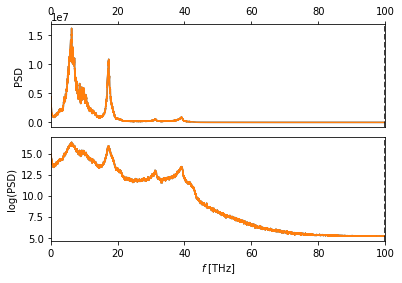

In [6]:
jf=j.resample_current(PSD_FILTER_W=0.1, fstar_THz=100)

In [7]:
np.sqrt(0.000001)

0.001

In [9]:
j.mel_cepstral_analysis(debug=True)
j.cepstral_analysis()
print('log mel-filter')
# jlog.mel_cepstral_analysis()

self.mel_psd_std[0]=  0.07068814764374858
-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 36  (P* = 37, corr_factor = 1.000000)
  L_0*   =          14.887260 +/-   0.070688
  S_0*   =     3827118.104781 +/- 270531.889641
-----------------------------------------------------
  Mel kappa* =           6.794043 +/-   0.480258  W/mK
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 176  (P* = 177, corr_factor = 1.000000)
  L_0*   =          14.300872 +/-   0.047714
  S_0*   =     2893819.803599 +/- 138075.459135
-----------------------------------------------------
  kappa* =           5.137217 +/-   0.245117  W/mK
-----------------------------------------------------

log mel-filter


In [11]:
0.242439 / 14.887260 
270531.889641 / 3827118.104781

0.07068814764379494

In [12]:
print(j.mel_psd_std[:5])
print(j.mel_psd_std_FFT[:5])
print(j.dct.tau_std_Kmin,j.kappa_scale)
138075.459135 * j.kappa_scale *0.5

[270531.88964083 275202.91431548 278307.64741279 279868.30754168
 279941.55259345]
[0.07068815 0.07196875 0.07296289 0.07367708 0.07412278]
138075.4591354817 3.5504749469394664e-06


0.24511672922299083

In [10]:
print(j.mel_psd_std[:10])
print(j.mel_psd_std_FFT[:10])
print(j.dct.tau_std_Kmin,j.kappa_scale)
#j.mel_bins

[0.07068815 0.07196875 0.07296289 0.07367708 0.07412278 0.07431616
 0.07427782 0.07403239 0.07360796 0.07303544]
[0.07068815 0.07196875 0.07296289 0.07367708 0.07412278 0.07431616
 0.07427782 0.07403239 0.07360796 0.07303544]
138075.4591354817 3.5504749469394664e-06


In [67]:
conv_cc=ifft(fft(j.covxi , axis = 1),axis=0)
conv_cc1=fft(ifft(j.covxi , axis = 0),axis=1)
print(conv_cc)
conv_cc[j.dct.aic_Kmin + 1:,:] = 0.
conv_cc[:,j.dct.aic_Kmin + 1:] = 0.
print(np.diag(ifft(fft(conv_cc , axis = 0),axis=1).real))
print(np.diag(ifft(fft(conv_cc1 , axis = 0),axis=1).real)[:6])


[[0.01753088+1.10579983e-19j 0.00776137-7.17439152e-03j
  0.00426478-4.84953456e-03j ... 0.00332241+3.43656722e-03j
  0.00426478+4.84953456e-03j 0.00776137+7.17439152e-03j]
 [0.00776137+7.17439152e-03j 0.0175303 +3.87029939e-19j
  0.00776096-7.17382571e-03j ... 0.00295995+2.61519953e-03j
  0.00332247+3.43684143e-03j 0.00426485+4.84972664e-03j]
 [0.00426478+4.84953456e-03j 0.00776096+7.17382571e-03j
  0.01752854+2.21159965e-19j ... 0.00278564+2.08845346e-03j
  0.00295996+2.61530493e-03j 0.00332247+3.43684143e-03j]
 ...
 [0.00332241-3.43656722e-03j 0.00295995-2.61519953e-03j
  0.00278564-2.08845346e-03j ... 0.0175256 -1.76927972e-18j
  0.00776015-7.17269417e-03j 0.00426458-4.84895837e-03j]
 [0.00426478-4.84953456e-03j 0.00332247-3.43684143e-03j
  0.00295996-2.61530493e-03j ... 0.00776015+7.17269417e-03j
  0.01752854-5.52899913e-19j 0.00776096-7.17382571e-03j]
 [0.00776137-7.17439152e-03j 0.00426485-4.84972664e-03j
  0.00332247-3.43684143e-03j ... 0.00426458+4.84895837e-03j
  0.00776096+7

<IPython.core.display.Javascript object>


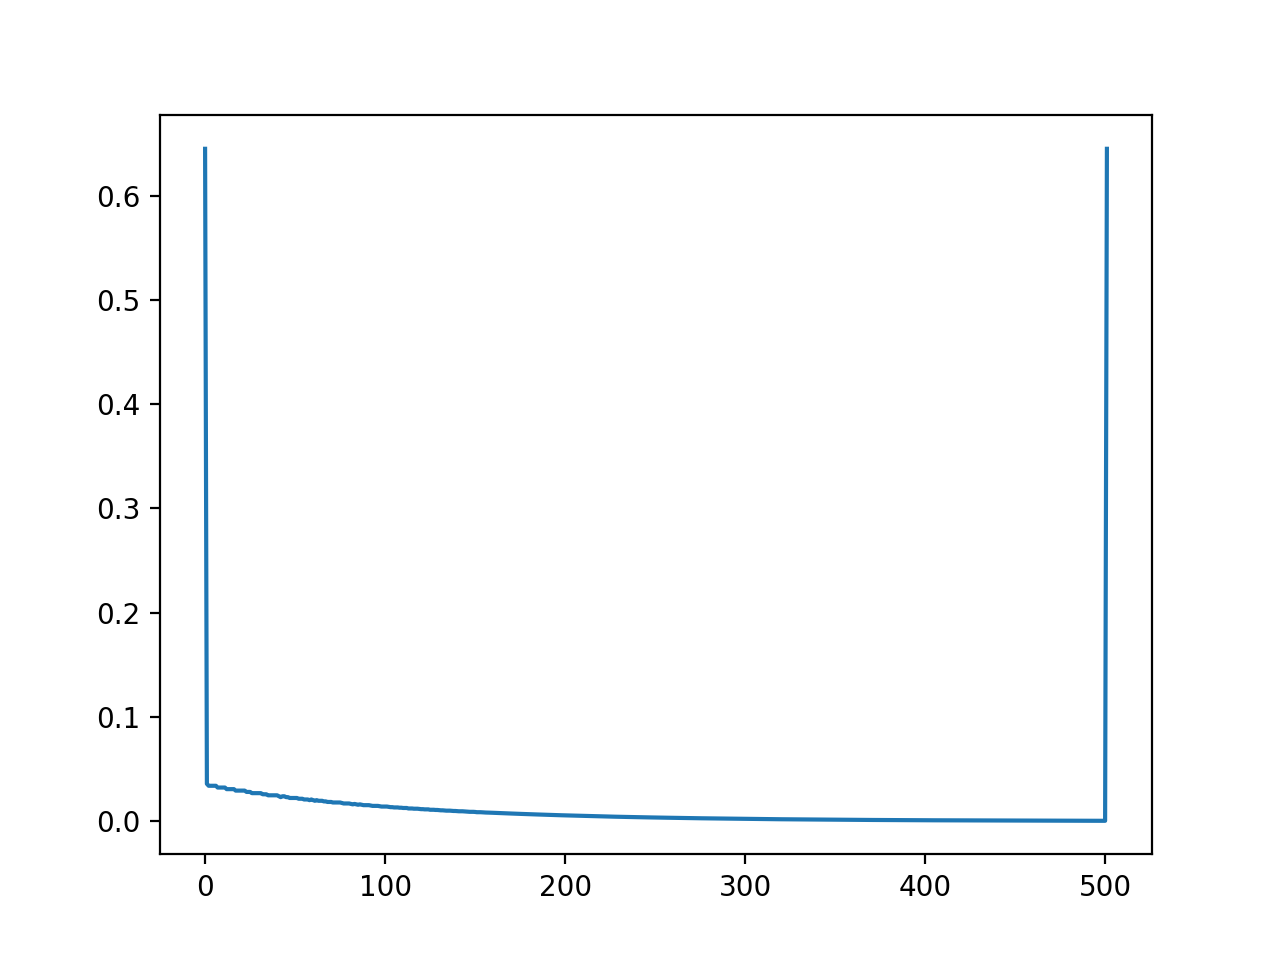

In [23]:
%matplotlib notebook

plt.plot(np.diag(j.covxi))

In [9]:
j.mel_psd_std*j.kappa_scale/2.

array([1.42565393e-06, 3.36029854e-07, 3.27067443e-07, 3.27067443e-07,
       3.27067443e-07, 3.27067443e-07, 3.27067443e-07, 3.18785910e-07,
       3.18785910e-07, 3.18785910e-07, 3.18785910e-07, 3.18785910e-07,
       3.11103193e-07, 3.11103193e-07, 3.11103193e-07, 3.11103193e-07,
       3.11103193e-07, 3.03950439e-07, 3.03950439e-07, 3.03950439e-07,
       3.03950439e-07, 3.03950439e-07, 3.03950439e-07, 2.97269394e-07,
       2.97269394e-07, 2.97269394e-07, 2.91010390e-07, 9.63432431e-08,
       9.58720472e-08, 9.52798988e-08, 9.45968150e-08, 9.38588323e-08,
       9.31041154e-08, 9.23691584e-08, 9.16853691e-08, 9.10763352e-08,
       9.05560313e-08, 9.01281388e-08, 8.97865089e-08, 8.95166550e-08,
       8.92980190e-08, 8.91066830e-08, 8.89181699e-08, 8.87100219e-08,
       8.84639139e-08, 8.81671511e-08, 8.78134803e-08, 8.74032146e-08,
       8.69427237e-08, 8.64433813e-08, 8.59200955e-08, 8.53895705e-08,
       8.48684713e-08, 8.43716733e-08, 8.39107711e-08, 8.34930029e-08,
      

<IPython.core.display.Javascript object>


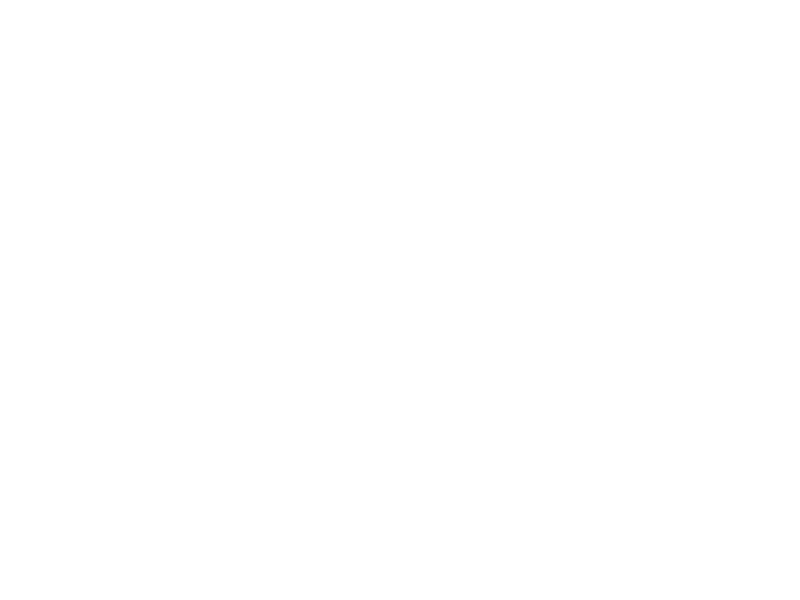

In [22]:
%matplotlib notebook
plt.plot(j.mel_psd_std*j.kappa_scale/2.)

In [11]:
# jr=j.resample_current(fstar_THz=1.0)[0]
j.cepstral_analysis()

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 176  (P* = 177, corr_factor = 1.000000)
  L_0*   =          14.300872 +/-   0.047714
  S_0*   =     2893819.803590 +/- 138075.459135
-----------------------------------------------------
  kappa* =           5.137217 +/-   0.245117  W/mK
-----------------------------------------------------



<IPython.core.display.Javascript object>


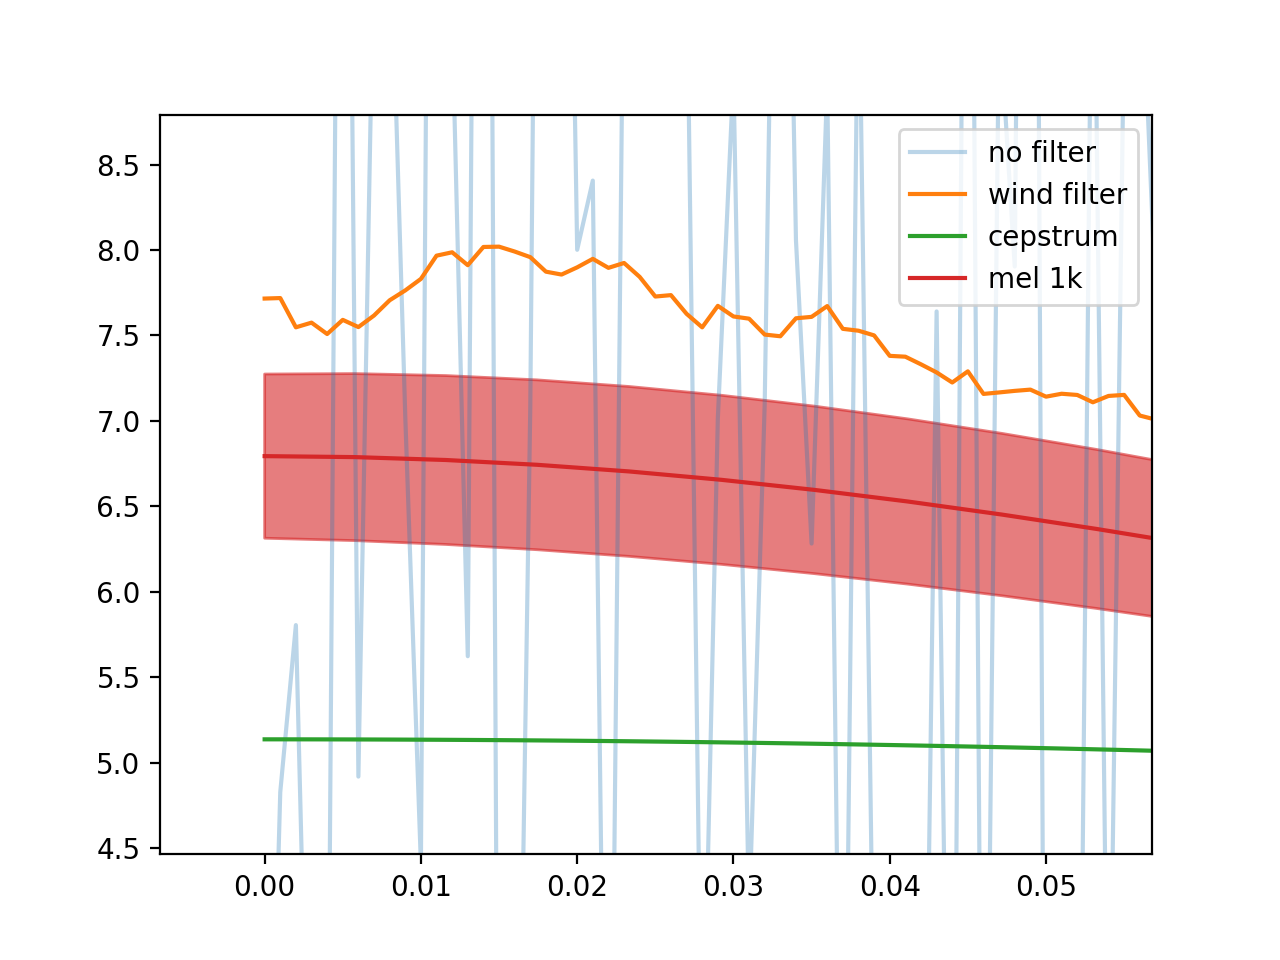

In [17]:
%matplotlib notebook
conv=j.kappa_scale/2
plt.plot(j.freqs_THz, j.psd*conv, label='no filter', alpha=0.3)
plt.plot(jf[0].freqs_THz, jf[0].fpsd*conv, label='wind filter')

plt.plot(j.freqs_THz, j.dct.psd*conv, label='cepstrum')
p=plt.plot(j.mel_filtered_freqs_THz, conv*j.mel_dct.psd, label='mel 1k')
plt.fill_between(j.mel_filtered_freqs_THz, conv*j.mel_dct.psd-conv*j.mel_psd_std , conv*j.mel_dct.psd+conv*j.mel_psd_std,alpha=0.6,color=p[0].get_color())
#plt.plot(j.mel_filtered_freqs_THz, conv*j.mel_filtered_psd, label='psd mel 1k',alpha=0.6)
#plt.plot(jlog.mel_filtered_freqs_THz, conv*jlog.mel_dct.psd, label='logmel 1k')
#plt.plot(jlog.mel2hz_rec(jlog.mel_points,jlog.mel_nrecursion)*1e-12, conv*np.exp(jlog.mel_filtered),'o-', label='logmel points')
#plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*j10k.mel_dct.psd, label='mel 10k')
#plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*j50k.mel_dct.psd, label='mel 50k')


# plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*jpsd_sq, label='sq')

#plt.plot(jnewfull.freqs_THz,jnewfull.psd*conv, label='media a blocchi') #,marker=marker,ms=ms,lw=lw)
#plt.plot(jnewfull.freqs_THz,jnewfull.dct.psd*conv, label='media a blocchi cepstral') #,marker=marker,ms=ms,lw=lw)


plt.legend()

## Prove FFT

In [13]:
covxi = np.random.normal(size=(10,10))
covxi = covxi + covxi.T
for i in range(len(covxi)):
    covxi[i,i] = covxi[i,i]**2

In [30]:
covxi[0]

array([ 1.18498189e+01, -1.08693999e+00, -1.18234631e-01, -3.67300296e-01,
        7.43854604e-03, -8.17742782e-01, -1.84723249e+00,  8.46017361e-01,
       -3.98129285e-01,  5.68846951e-01])

In [34]:
irfft(rfft(covxi, axis = 1), axis = 0)

array([[  5.28218045,   3.72044044,  -0.13195927,  -1.4529916 ,
         -1.55673154,  -0.11714915,  -2.5816563 ,  -0.56051506,
         -3.39732923,   1.10498473],
       [ -3.63241446,   1.89250474,  -6.15427239,   5.84325628,
         -6.49393655,   4.25911506,   2.47828528,  -1.50570898,
          5.15370585,  -4.80763151],
       [  9.93061302,   4.13819685,  10.28965929,  -5.95984158,
          2.01169487,  -5.08043047,  -3.46378546,   5.18636113,
         -7.54902944,   4.97533477],
       [-12.32641457,  -3.52258707,  -5.80066858,  10.54638873,
         -1.65033466,   7.50916763,   4.0336596 ,  -0.67500635,
          8.88771886,  -4.82336222],
       [  5.97622188,  -0.76901621,   3.70969449,  -0.79742415,
          6.02436953,  -1.71750387,  -3.06246027,   3.07055434,
         -0.75764012,   9.72540594],
       [  2.11257277,   1.54708297,   1.35186574,   0.46265666,
          1.34360273,   1.47695638,   2.54253596,   1.81824602,
          1.37997884,   3.32531481],
       [ -

In [41]:
tmp = ifft(fft(covxi, axis=1), axis=0)
tmp[4:, 4:] = 0.0
np.diag(ifft(fft(tmp, axis=1), axis=0).real)

array([ 5.56217122, -4.23205998, 28.68980229, -3.4367203 , -0.86784575,
       -1.26689124,  4.7767631 ,  0.98767477, -0.79032497,  5.71036322])

In [10]:
f=fft(np.random.normal(size=100))

<IPython.core.display.Javascript object>


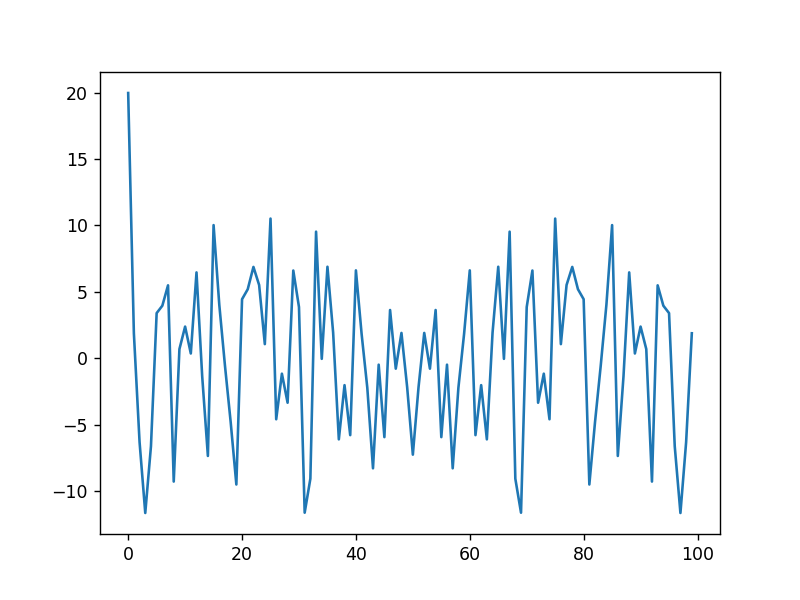

In [13]:
%matplotlib notebook
plt.plot(f.real)

In [14]:
covxi

NameError: name 'covxi' is not defined

In [27]:
n1,n2=covxi.shape
fc = np.zeros(covxi.shape, dtype = np.complex)
fcc = np.zeros(covxi.shape, dtype = np.complex)

for m in range(n2):
    fc[:, m] = np.sum(covxi * np.exp(2*np.pi*1j*m*np.arange(n2)/n2), axis=1)
for n in range(n1):
    fc[n, :] = np.mean(fc * np.exp(-2*np.pi*1j*n*np.arange(n1)/n1), axis=0)
fc[4:, 4:] = 0.0   
for j in range(n2):
    fcc[:, j] = np.sum(fc * np.exp(2*np.pi*1j*j*np.arange(n2)/n2), axis=1)
for j in range(n1):
    fcc[j, :] = np.mean(fcc * np.exp(-2*np.pi*1j*j*np.arange(n1)/n1), axis=0)
    

In [45]:
r1 = np.arange(n1)
r2 = np.arange(n2)
rs1 = np.arange(n1)
rs1[4:] = 0
rs2 = np.arange(n2)
rs2[4:] = 0

eps = np.exp(2*np.pi*1j*np.outer(r1, rs2)/n1)
ems = np.exp(-2*np.pi*1j*np.outer(r1, rs2)/n1)
ep  = np.exp(2*np.pi*1j*np.outer(r1, r2)/n1)
em  = np.exp(-2*np.pi*1j*np.outer(r1, r2)/n1)

In [43]:
rs1

array([0, 1, 2, 3, 0, 0, 0, 0, 0, 0])

In [51]:
cacca=np.einsum('am,bn,jn,mi,ji->ab', eps, ems, ep, em, covxi)

In [53]:
np.diag(cacca).real

array([ 13.86518275,  20.96480727,   8.19217098,  24.58919425,
        17.17074262, -11.27099686,  86.39999693, 228.78051832,
       187.71495494,  50.27952523])